In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')


# LightGBM
import lightgbm as lgb

In [32]:
def drop_data(df):
    df =df.drop("Id", axis=1)
    df =df.drop("groupId", axis=1)
    df =df.drop("matchId", axis=1)
    df =df.drop("matchType", axis=1)
    return df

In [36]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
path = "../input/"

df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df_sub = pd.read_csv(path + 'submission.csv')

In [4]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は7134、変数は29種類です。
テストデータのデータ数は1794、変数は28種類です


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7134 entries, 0 to 7133
Data columns (total 29 columns):
Id                 7134 non-null object
groupId            7134 non-null object
matchId            7134 non-null object
assists            7134 non-null int64
boosts             7134 non-null int64
damageDealt        7134 non-null float64
DBNOs              7134 non-null int64
headshotKills      7134 non-null int64
heals              7134 non-null int64
killPlace          7134 non-null int64
killPoints         7134 non-null int64
kills              7134 non-null int64
killStreaks        7134 non-null int64
longestKill        7134 non-null float64
matchDuration      7134 non-null int64
matchType          7134 non-null object
maxPlace           7134 non-null int64
numGroups          7134 non-null int64
rankPoints         7134 non-null int64
revives            7134 non-null int64
rideDistance       7134 non-null float64
roadKills          7134 non-null int64
swimDistance       7134 n

In [6]:
df_test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,c9ce5e5749758a,d1d34623858d02,6533442a513d6f,0,0,100.0,1,1,0,38,...,1431,0,0.0,0,0.0,0,0,168.4,1,0
1,262418e6a1fd89,f0290ae9582198,976f4ae3c91669,0,0,0.0,0,0,0,76,...,-1,0,0.0,0,0.0,0,0,280.7,3,1639
2,1fdaad049557d9,d1d34623858d02,6533442a513d6f,1,0,57.0,1,0,0,71,...,1490,0,0.0,0,0.0,0,0,202.7,4,0
3,cb1761d22b957e,77234d376925f9,efd749a746587e,0,0,0.0,0,0,1,72,...,-1,0,0.0,0,0.0,0,0,123.1,2,1465
4,1b86424e60c2e8,19a7b7ce87c841,098d3f2da942e7,0,1,348.1,1,0,2,16,...,-1,0,0.0,0,0.0,0,0,1372.0,5,1398


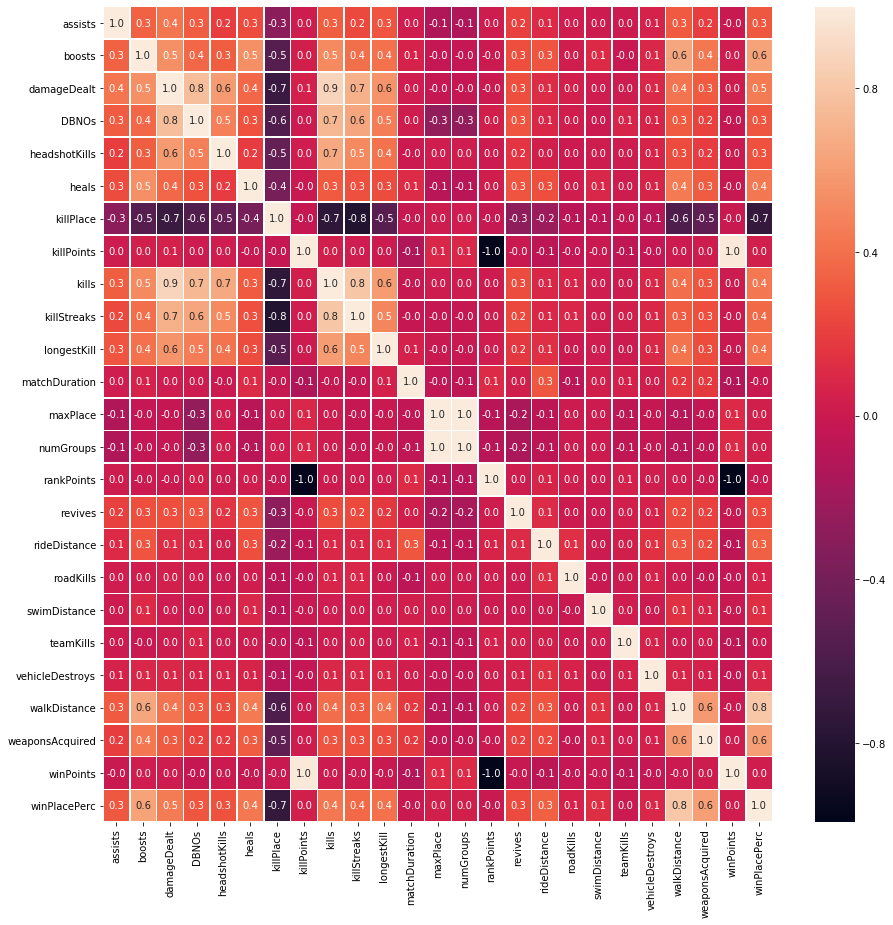

In [10]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

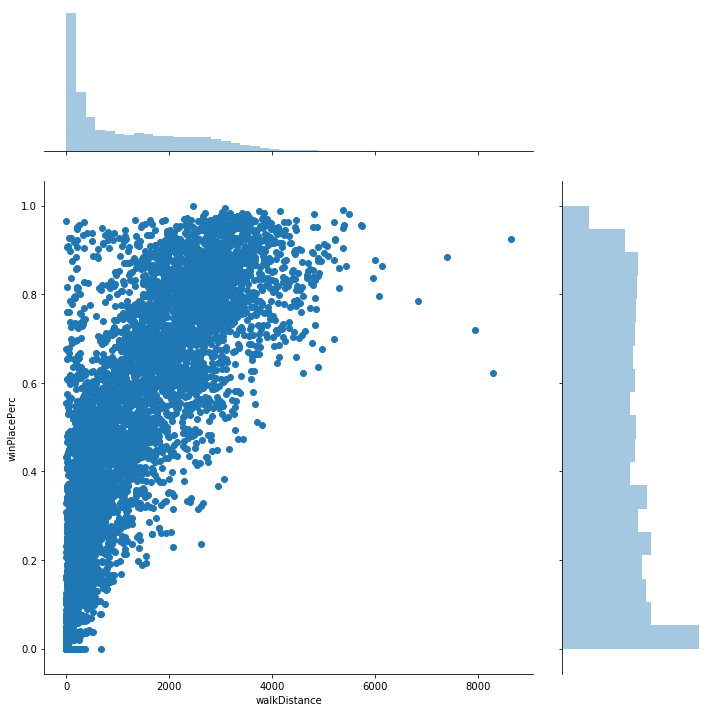

In [17]:
data = df.copy()
sns.jointplot(x="walkDistance", y="winPlacePerc", data=data, height=10, ratio=3)
plt.show()

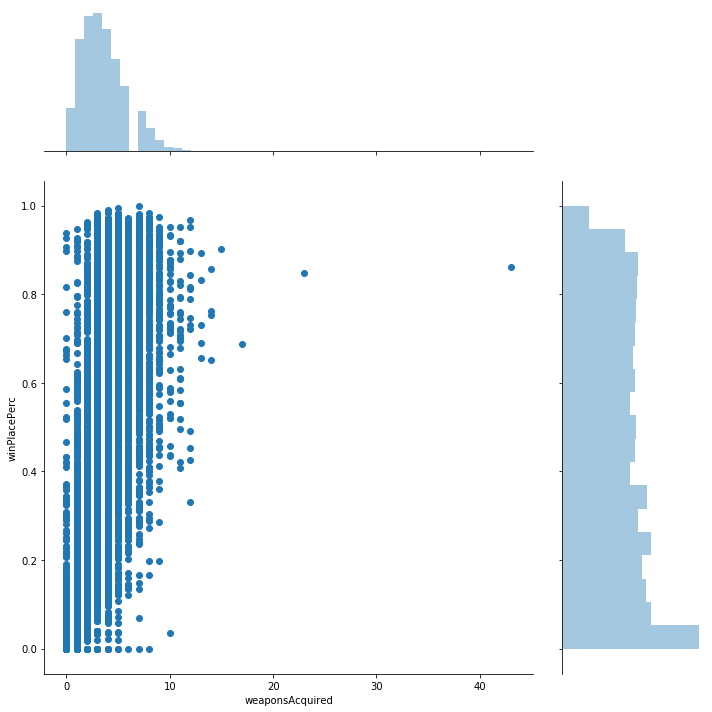

In [18]:
data = df.copy()
sns.jointplot(x="weaponsAcquired", y="winPlacePerc", data=data, height=10, ratio=3)
plt.show()

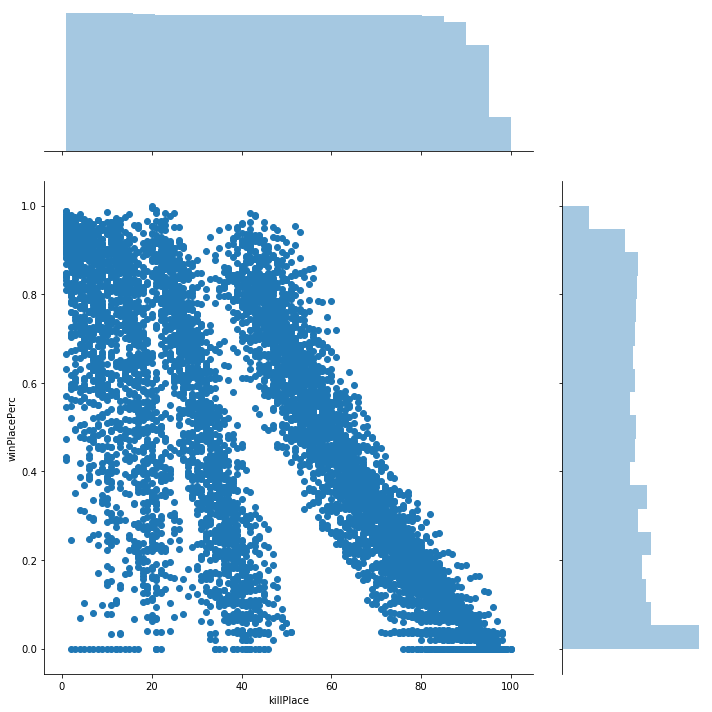

In [33]:
x = df.drop(columns='winPlacePerc')
x = drop_data(x)
y = df['winPlacePerc']

In [34]:
train_X, valid_X, train_y, valid_y = train_test_split(x, y, test_size=0.3, random_state=42)


In [35]:
train_X, valid_X, train_y, valid_y = train_test_split(x, y, test_size=0.3, random_state=42)
params = {"objective" : "regression", "metric" : "mae", 'n_estimators':20000, 'early_stopping_rounds':200,
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.7,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.7
             }
lgtrain = lgb.Dataset(train_X, label=train_y)
lgval = lgb.Dataset(valid_X, label=valid_y)
model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], early_stopping_rounds=200, verbose_eval=1000)

Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.0151501	valid_1's l1: 0.0493112
[2000]	training's l1: 0.00747453	valid_1's l1: 0.0487317
Early stopping, best iteration is:
[2403]	training's l1: 0.00585473	valid_1's l1: 0.048667


In [45]:
x_test = df_test
x_test = drop_data(x_test)
pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)

In [52]:
df_sub['winPlacePerc'] = pred_test_y

In [54]:
df_sub.to_csv('out.csv',index=False)